In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import zarr
import gcsfs
import momlevel as ml

In [2]:
from dask.distributed import Client
from dask.distributed import LocalCluster
client = Client(dashboard_address=':8081')
client


/home/tu.temple.edu/tun27673/miniconda3/envs/antarctic_southernocean_2/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8081 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33857 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33857/status,
Dashboard: http://127.0.0.1:33857/status,Workers: 14
Total threads: 112,Total memory: 755.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36487,Workers: 14
Dashboard: http://127.0.0.1:33857/status,Total threads: 112
Started: Just now,Total memory: 755.56 GiB
Comm: tcp://127.0.0.1:40249,Total threads: 8
Dashboard: http://127.0.0.1:39523/status,Memory: 53.97 GiB
Nanny: tcp://127.0.0.1:44243,


In [4]:
seaice = xr.open_mfdataset('/backup/tuq41374/model_output/sofia/antwater/gfdl-cm4/ice/siconc/*.nc' ,chunks={'time':1,'z_l':1},drop_variables=['average_DT', 'average_T1', 'average_T2'],)
static = xr.open_dataset('/backup/tuq41374/model_output/sofia/antwater/gfdl-cm4/static/static_files/ice.static.nc' ,chunks={'time':1,'z_l':1},drop_variables=['average_DT', 'average_T1', 'average_T2'],)
ice = seaice.siconc
ice

<xarray.DataArray 'siconc' (time: 1200, yT: 1080, xT: 1440)>
dask.array<concatenate, shape=(1200, 1080, 1440), dtype=float32, chunksize=(1, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0100-12-16 12:00:00
  * xT       (xT) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yT       (yT) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Attributes:
    long_name:      ice concentration
    units:          0-1
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [5]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

df_si = df.query("source_id=='GFDL-CM4' & experiment_id == 'piControl' & variable_id == 'siconc' & grid_label=='gn' ")

gcs = gcsfs.GCSFileSystem(token='anon')

zstore = df_si.zstore.values[-1]

mapper = gcs.get_mapper(zstore)

ds = xr.open_zarr(mapper, consolidated=True)
ds.siconc.rename({'x':'xT'}).rename({'y':'yT'})


<xarray.DataArray 'siconc' (time: 6000, yT: 1080, xT: 1440)>
dask.array<open_dataset-4c50cf3bf33148b971428f2794cf359dsiconc, shape=(6000, 1080, 1440), dtype=float32, chunksize=(60, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
    lat      (yT, xT) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon      (yT, xT) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * time     (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
  * xT       (xT) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yT       (yT) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Ice Area Fraction (Ocean Grid)
    original_name:  siconc
    standard_name:  sea_ice_area_fraction
    units:          %

In [6]:
PIice = ds.siconc.sel(time=slice("0251-01-16", "0350-12-16"))
PIice = PIice.rename({'x':'xT'}).rename({'y':'yT'})

In [7]:
last = ice.sel(time=slice("0080-01-16", "0100-12-16")).mean(dim="time")
last

<xarray.DataArray 'siconc' (yT: 1080, xT: 1440)>
dask.array<mean_agg-aggregate, shape=(1080, 1440), dtype=float32, chunksize=(1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * xT       (xT) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yT       (yT) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95

In [8]:
picontrol = ds.siconc.sel(time=slice("0251-01-16", "0350-12-16")).mean(dim="time")
picont = picontrol.rename({'x':'xT'}).rename({'y':'yT'})
picont
#PICont =  ds.siconc.sel(time=slice("0251-01-16", "0350-12-16"))

<xarray.DataArray 'siconc' (yT: 1080, xT: 1440)>
dask.array<mean_agg-aggregate, shape=(1080, 1440), dtype=float32, chunksize=(1080, 1440), chunktype=numpy.ndarray>
Coordinates:
    lat      (yT, xT) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon      (yT, xT) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * xT       (xT) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yT       (yT) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95

In [12]:
picont['geolat'] = static.GEOLAT
picont['geolon'] = static.GEOLON
diff['geolat'] = static.GEOLAT
diff['geolon'] = static.GEOLON
ice['geolat'] = static.GEOLAT
ice['geolon'] = static.GEOLON
last['geolat'] = static.GEOLAT
last['geolon'] = static.GEOLON


In [13]:
seaice = seaice.assign_coords({'geolon': static['GEOLON'],
                                       'geolat': static['GEOLAT']})

In [14]:
ice

<xarray.DataArray 'siconc' (time: 1200, yT: 1080, xT: 1440)>
dask.array<concatenate, shape=(1200, 1080, 1440), dtype=float32, chunksize=(1, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0100-12-16 12:00:00
  * xT       (xT) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yT       (yT) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
    geolat   (yT, xT) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    geolon   (yT, xT) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
Attributes:
    long_name:      ice concentration
    units:          0-1
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [15]:
diff = picont - last # usually to find the difference we would subtract the picont from the last twenty years ( last - picont) but in this case, we expect more sea ice to be present in the later twenty years, so to show a positive difference
                     # we subtract picont from the last twenty
diff

<xarray.DataArray 'siconc' (yT: 1080, xT: 1440)>
dask.array<sub, shape=(1080, 1440), dtype=float32, chunksize=(1080, 1440), chunktype=numpy.ndarray>
Coordinates:
    lat      (yT, xT) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon      (yT, xT) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * xT       (xT) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yT       (yT) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
    geolat   (yT, xT) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    geolon   (yT, xT) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>

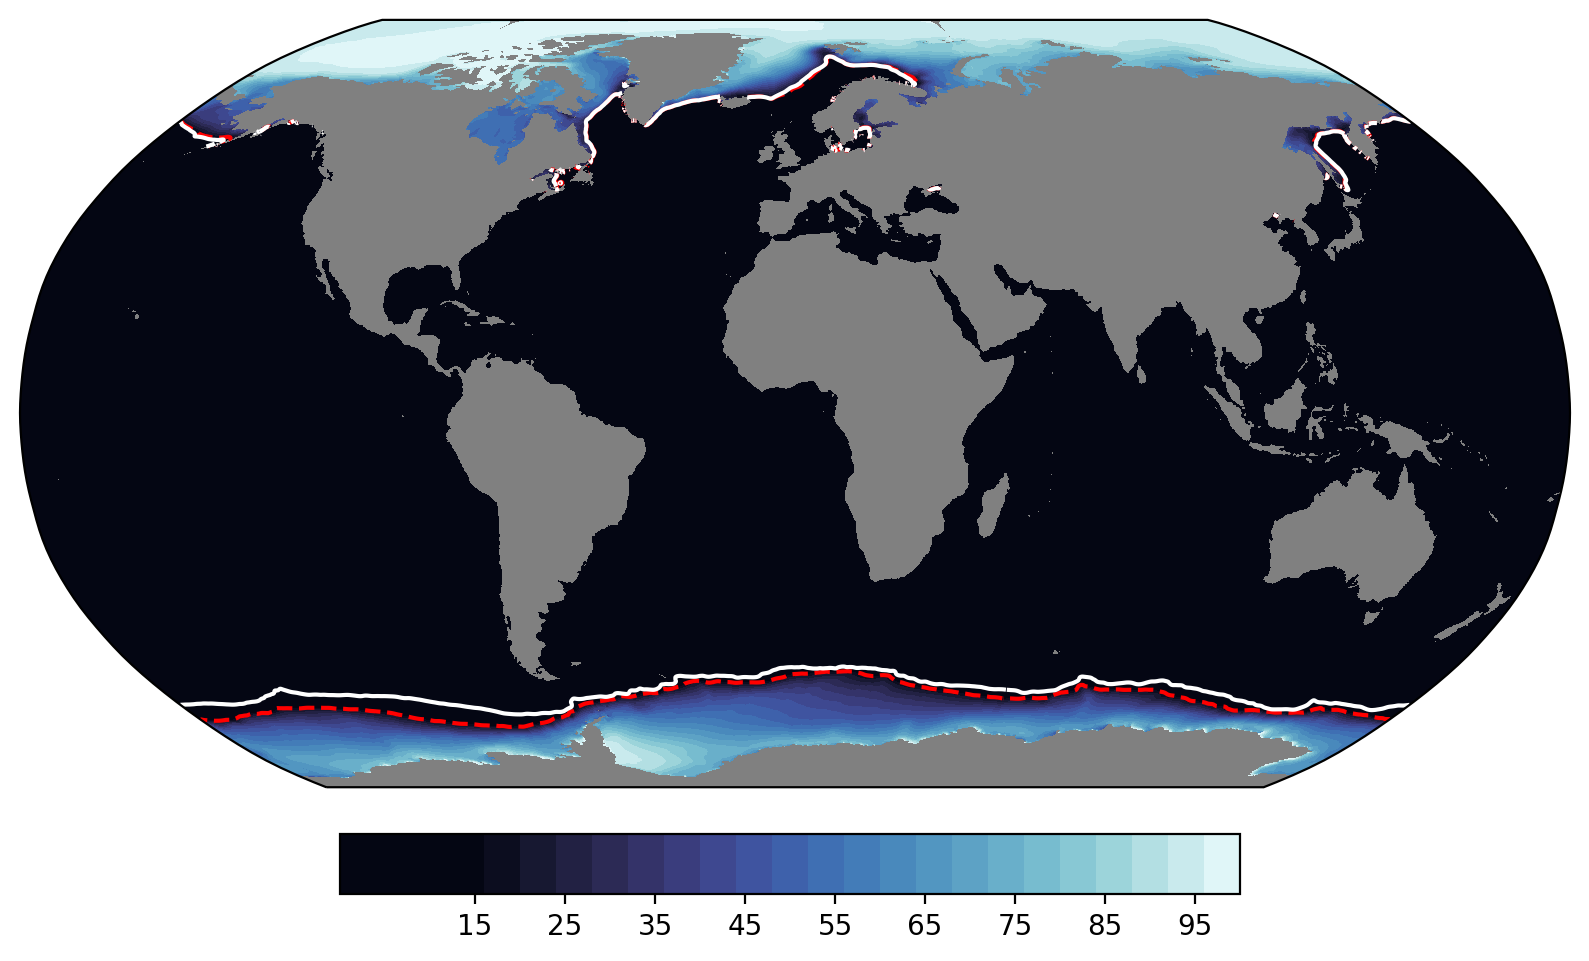

In [16]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw = dict(projection=ccrs.Robinson(), facecolor='grey'))

ax.contourf(picont.geolon,picont.geolat,picont,
            cmap=cmocean.cm.ice,
            vmin=15,vmax=100,
            levels= 30, transform=ccrs.PlateCarree())
ax.contour(picont.geolon,picont.geolat,picont,levels=[15], colors='red',transform=ccrs.PlateCarree(), linestyles='--')

ax.contour(last.geolon,last.geolat,last,levels=[.15], colors='white',transform=ccrs.PlateCarree(), linestyles='-')

cbar_diff= (ax.contourf(picont.geolon,picont.geolat,picont,
            cmap=cmocean.cm.ice,
            vmin=15,vmax=100,
            levels= 30, transform=ccrs.PlateCarree()))
cax = fig.add_axes([0.285, 0.25, 0.45, 0.03])
cbar_1=plt.colorbar(cbar_diff,cax=cax,orientation='horizontal',shrink=0.5,ticks = [15,25,35,45,55,65,75,85,95])
#plt.tight_layout()

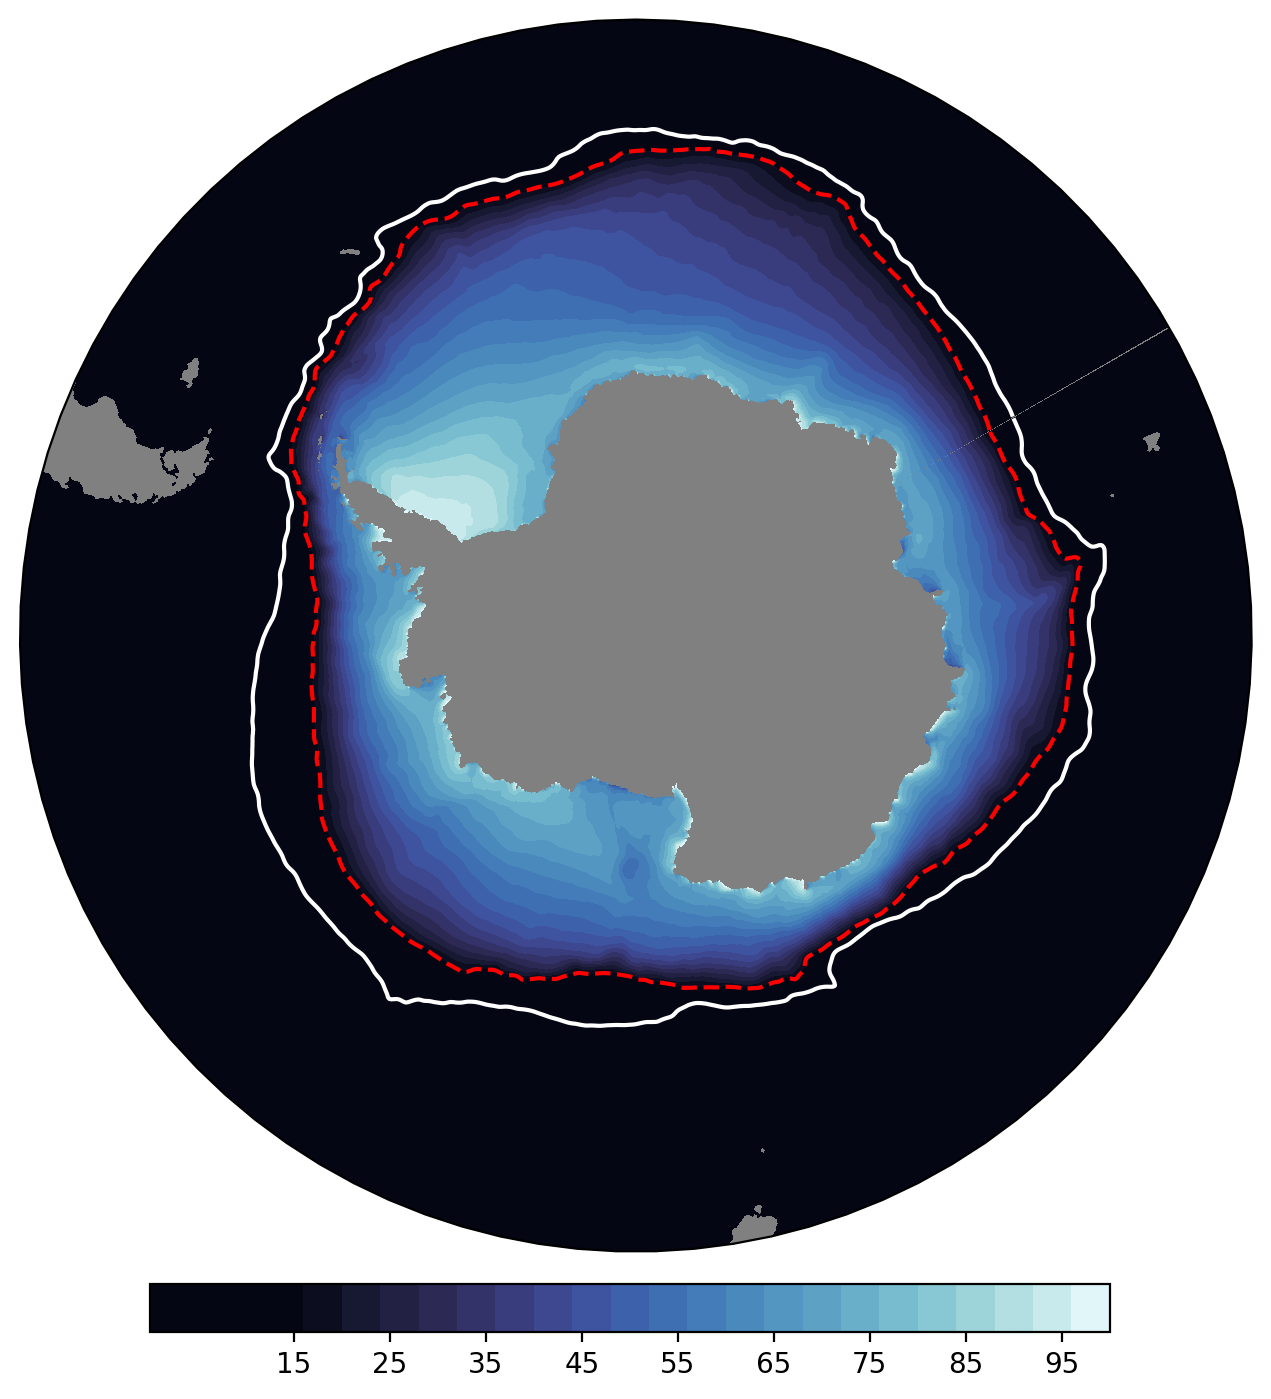

In [17]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw = dict(projection=ccrs.SouthPolarStereo(), facecolor='grey'))

ax.contourf(picont.geolon,picont.geolat,picont,
            cmap=cmocean.cm.ice,
            vmin=15,vmax=100,
            levels= 30, transform=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.contour(picont.geolon,picont.geolat,picont,levels=[15], colors='red',transform=ccrs.PlateCarree(), linestyles='--')
ax.contour(last.geolon,last.geolat,last,levels=[.15], colors='white',transform=ccrs.PlateCarree(), linestyles='-')

ax.set_extent([-180,180,-90,-45], ccrs.PlateCarree())
ax.set_boundary(circle,transform=ax.transAxes)

cbar_diff= (ax.contourf(picont.geolon,picont.geolat,picont,
            cmap=cmocean.cm.ice,
            vmin=15,vmax=100,
            levels= 30, transform=ccrs.PlateCarree()))

cax = fig.add_axes([0.31, 0.06, 0.40, 0.03])
cbar_1=plt.colorbar(cbar_diff,cax=cax,orientation='horizontal',shrink=0.5,ticks = [15,25,35,45,55,65,75,85,95])


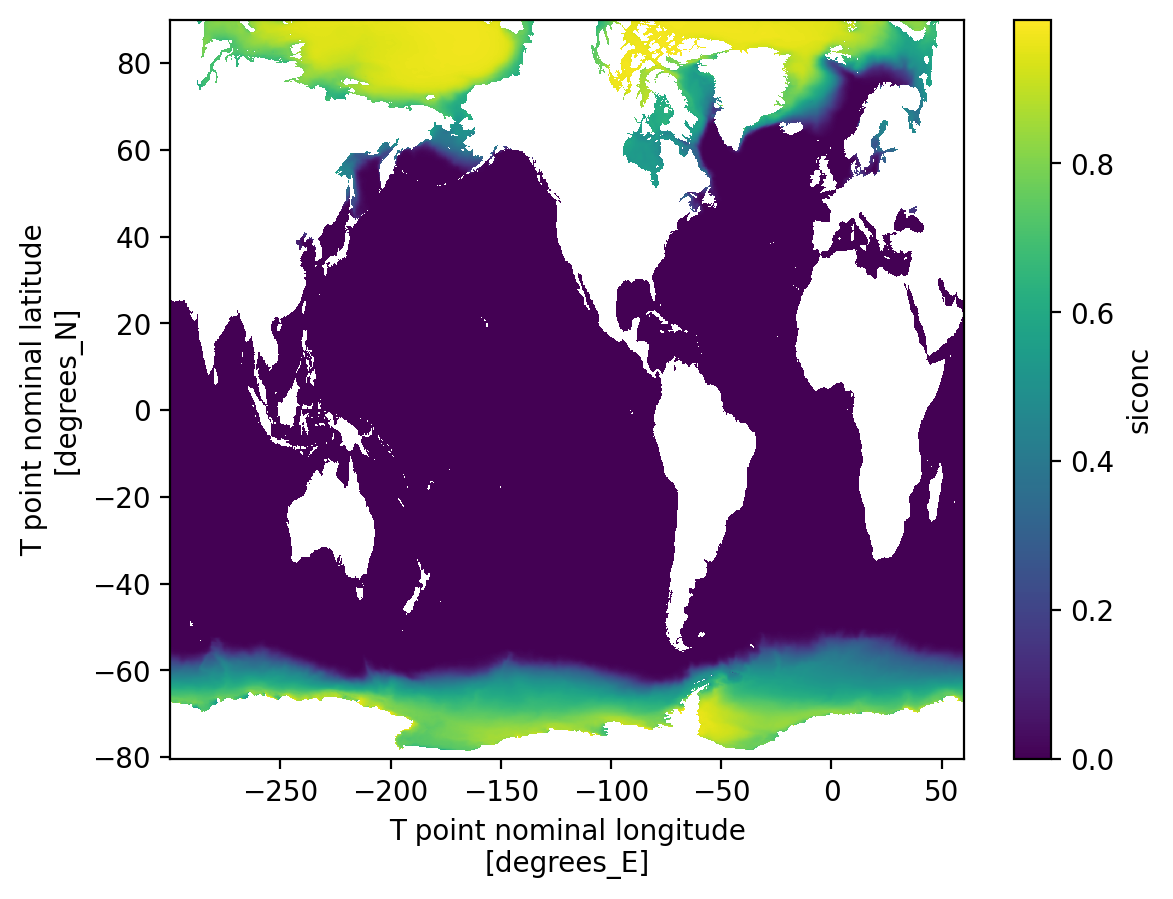

In [18]:
last.plot()

In [20]:
ax.contour(last.geolon,last.geolat,last,levels=[15], colors='white',transform=ccrs.PlateCarree(), linestyles='-')

Text(0.5, 1.0, '100 Year Pre-Industrial Average')

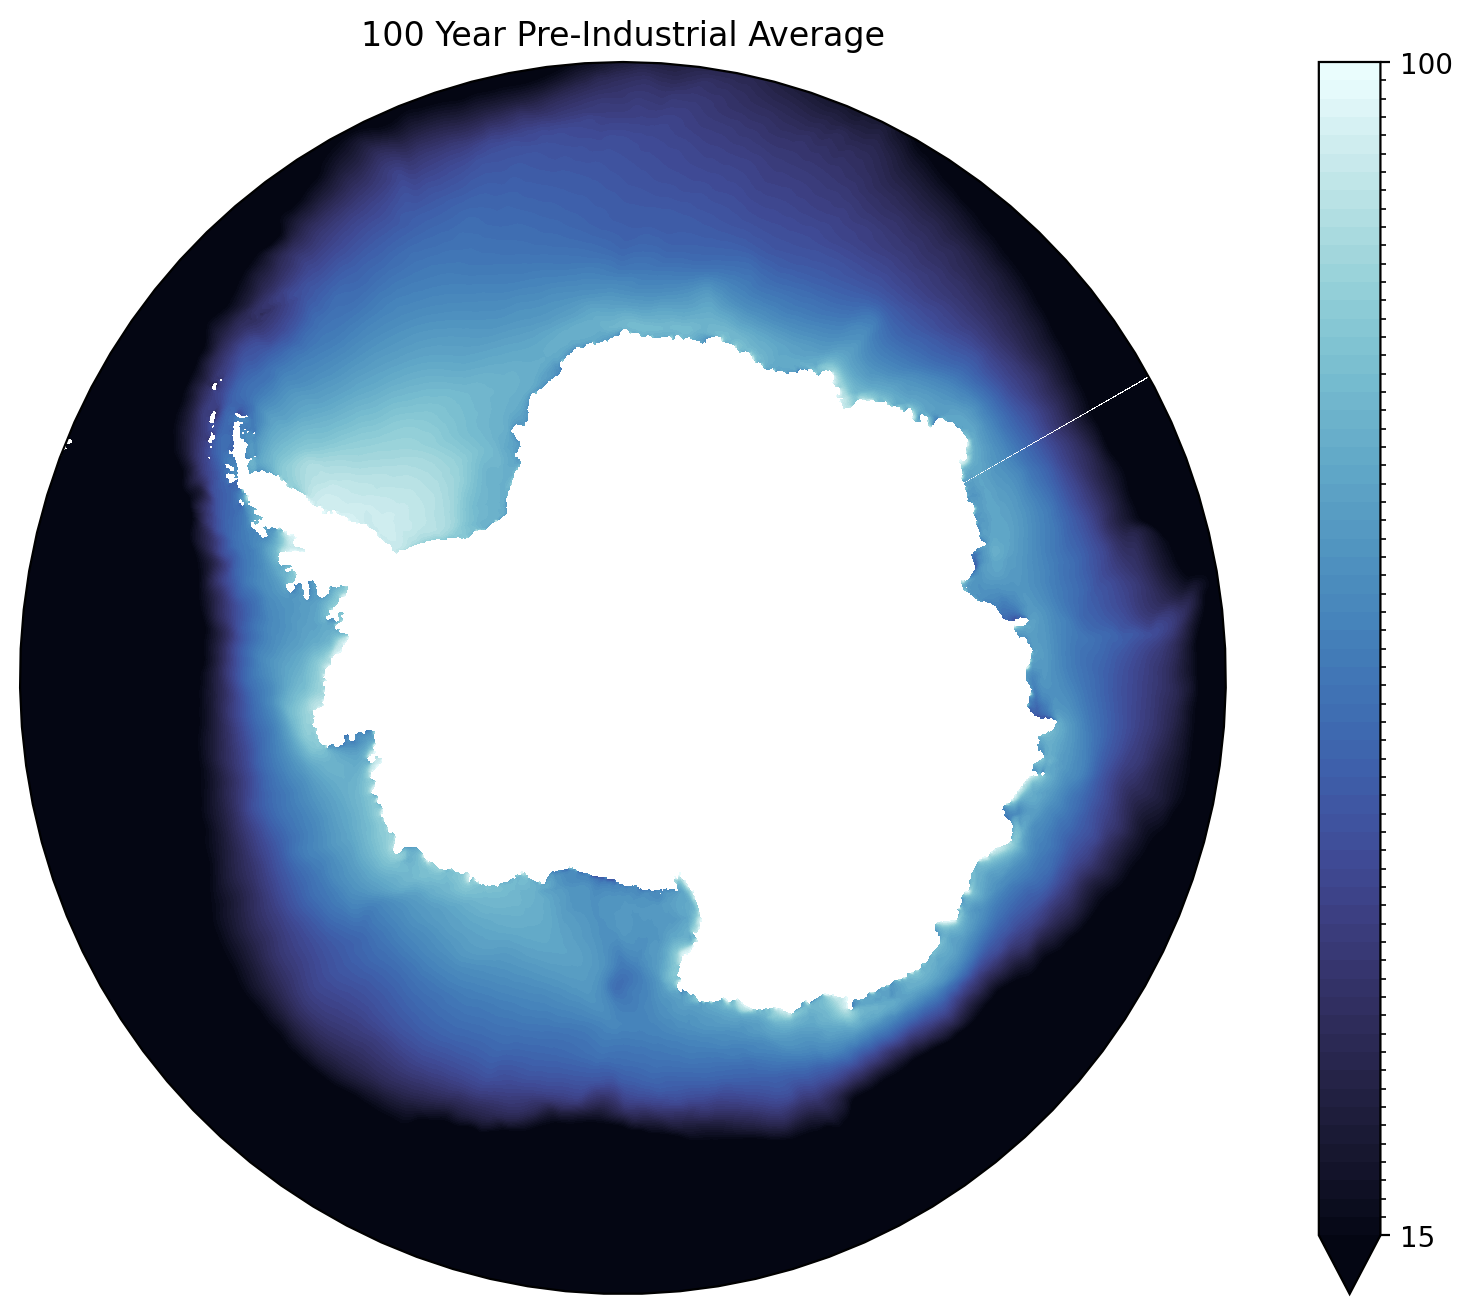

In [21]:
area = static['area']
area

shelf = area.where(area>15)*0
shelf_mask = shelf.isin(0)

x_seaice = ice.xT.values
y_seaice = ice.yT.values
xT,yT = np.meshgrid(x_seaice,y_seaice)

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

plt.figure(figsize=[12,8])

projection=ccrs.SouthPolarStereo()
ax = plt.axes(projection=projection)
ax.set_extent([-180,180,-90,-55], ccrs.PlateCarree())
ax.set_boundary(circle,transform=ax.transAxes)
#p.axes.coastlines()

p = picontrol.plot.contourf(x='x', y='y',
                        vmin=15,vmax=100,
                        cmap=cmocean.cm.ice,
                        transform=ccrs.PlateCarree(),add_colorbar=False, levels= 65)



cb = plt.colorbar(p, ticks=[15,100],extend='both')
plt.title("100 Year Pre-Industrial Average")

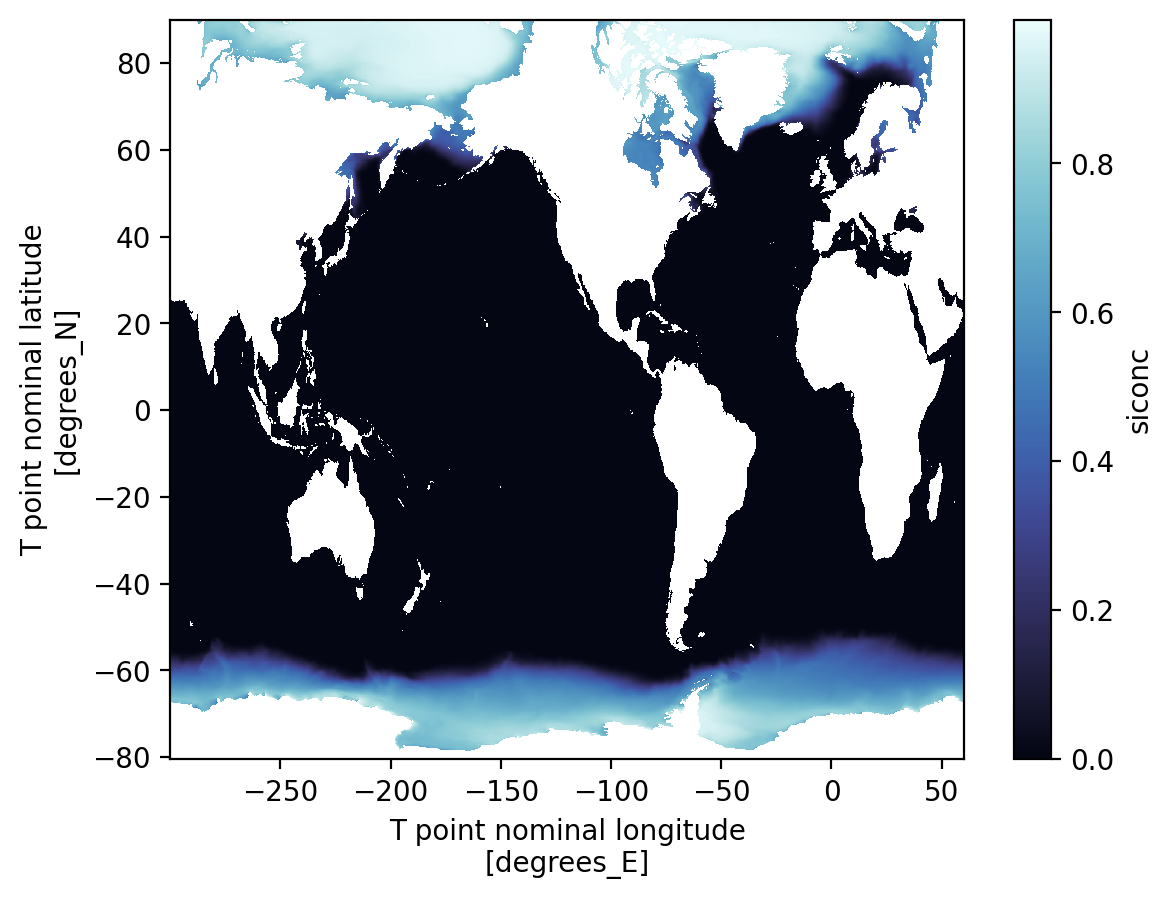

In [20]:
last.plot(cmap=cmocean.cm.ice)

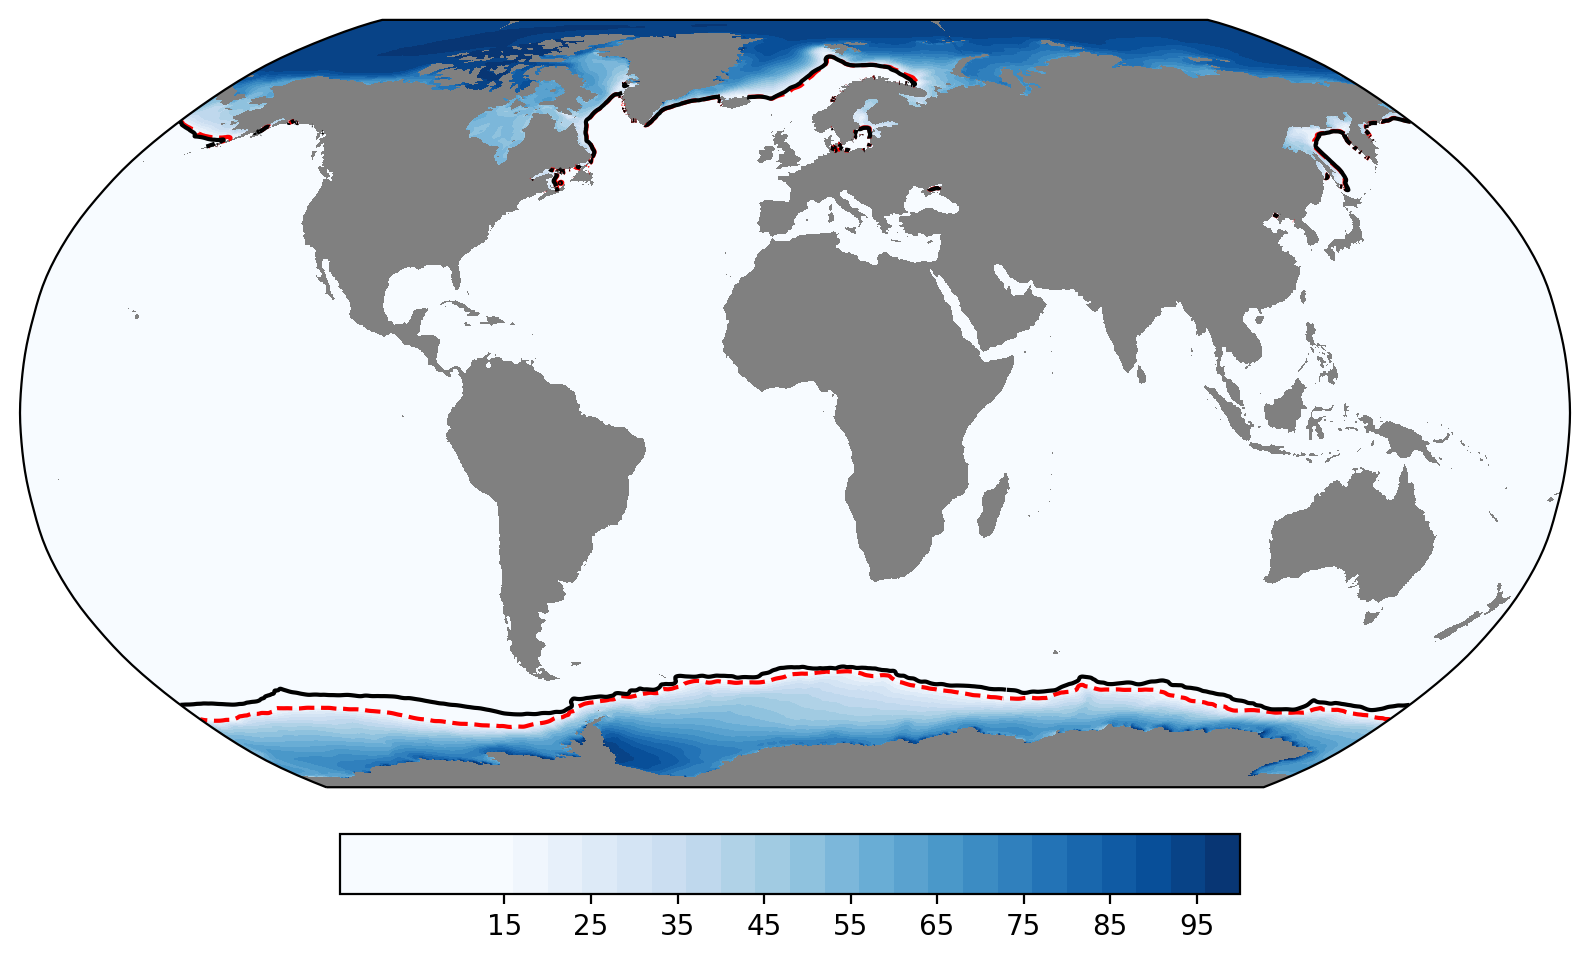

In [23]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw = dict(projection=ccrs.Robinson(), facecolor='grey'))
#levels=np.linspace(15,100,30)

ax.contourf(diff.geolon,diff.geolat,diff,
            cmap='Blues',
            vmin=15, vmax=100,
            levels=30, transform=ccrs.PlateCarree())
ax.contour(picont.geolon,picont.geolat,picont,levels=[15], colors='red',transform=ccrs.PlateCarree(), linestyles='--')

ax.contour(last.geolon,last.geolat,last,levels=[.15], colors='k',transform=ccrs.PlateCarree(), linestyles='-')
            
cbar_diff= (ax.contourf(diff.geolon,diff.geolat,diff,
            cmap='Blues',
            vmin=15, vmax=100,
            levels=30, transform=ccrs.PlateCarree()))
cax = fig.add_axes([0.285, 0.25, 0.45, 0.03])
cbar_1=plt.colorbar(cbar_diff,cax=cax,orientation='horizontal',shrink=0.5,ticks = [15,25,35,45,55,65,75,85,95])
#plt.tight_layout()

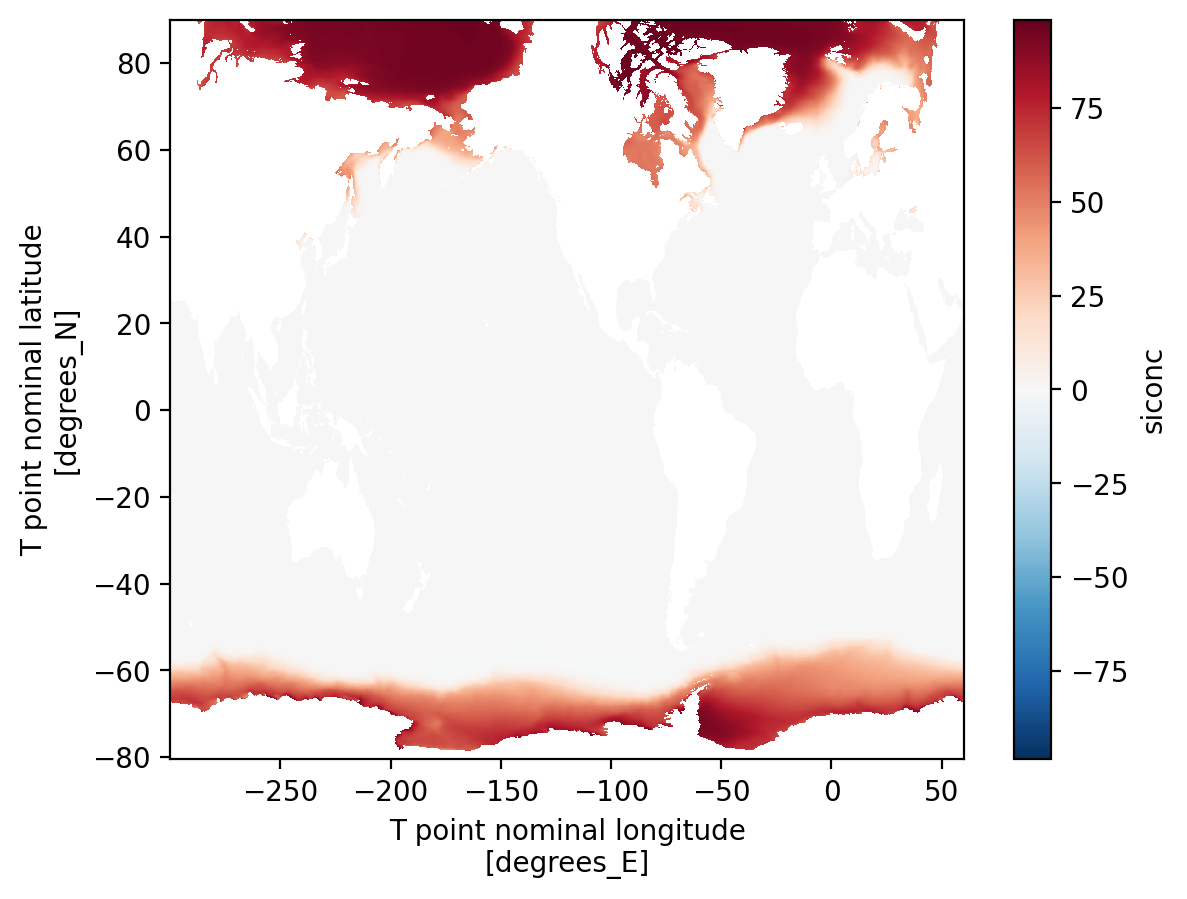

In [24]:
diff.plot()

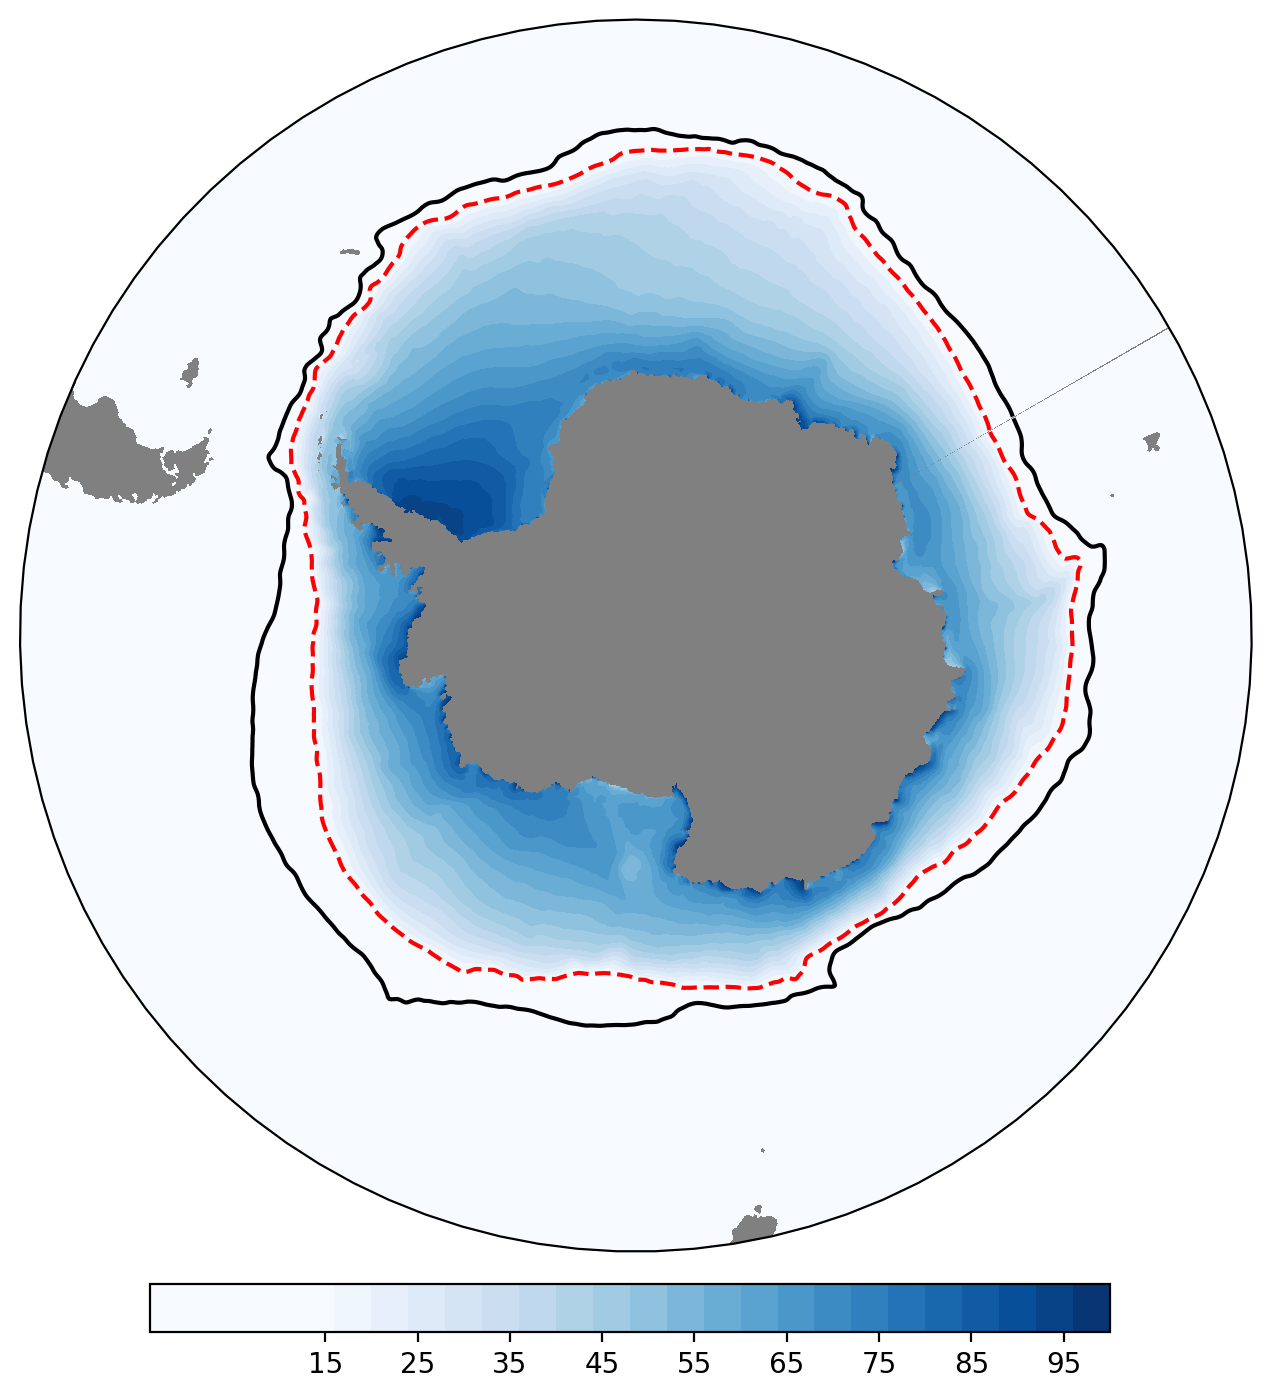

In [26]:
area = static['area']
area

shelf = area.where(area>15)*0
shelf_mask = shelf.isin(0)

fig, ax = plt.subplots(figsize=(12,8), subplot_kw = dict(projection=ccrs.SouthPolarStereo(), facecolor='grey'))

ax.contourf(diff.geolon,diff.geolat,diff,
            cmap='Blues',
            vmin=15,vmax=100,
            levels= 30, transform=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.contour(picont.geolon,picont.geolat,picont,levels=[15], colors='red',transform=ccrs.PlateCarree(), linestyles='--')
ax.contour(last.geolon,last.geolat,last,levels=[.15], colors='k',transform=ccrs.PlateCarree(), linestyles='-')

ax.set_extent([-180,180,-90,-45], ccrs.PlateCarree())
ax.set_boundary(circle,transform=ax.transAxes)

cbar_diff= (ax.contourf(diff.geolon,diff.geolat,diff,
            cmap='Blues',
            vmin=15, vmax=100,
            levels=30, transform=ccrs.PlateCarree()))

cax = fig.add_axes([0.31, 0.06, 0.40, 0.03])
cbar_1=plt.colorbar(cbar_diff,cax=cax,orientation='horizontal',shrink=0.5,ticks = [15,25,35,45,55,65,75,85,95])

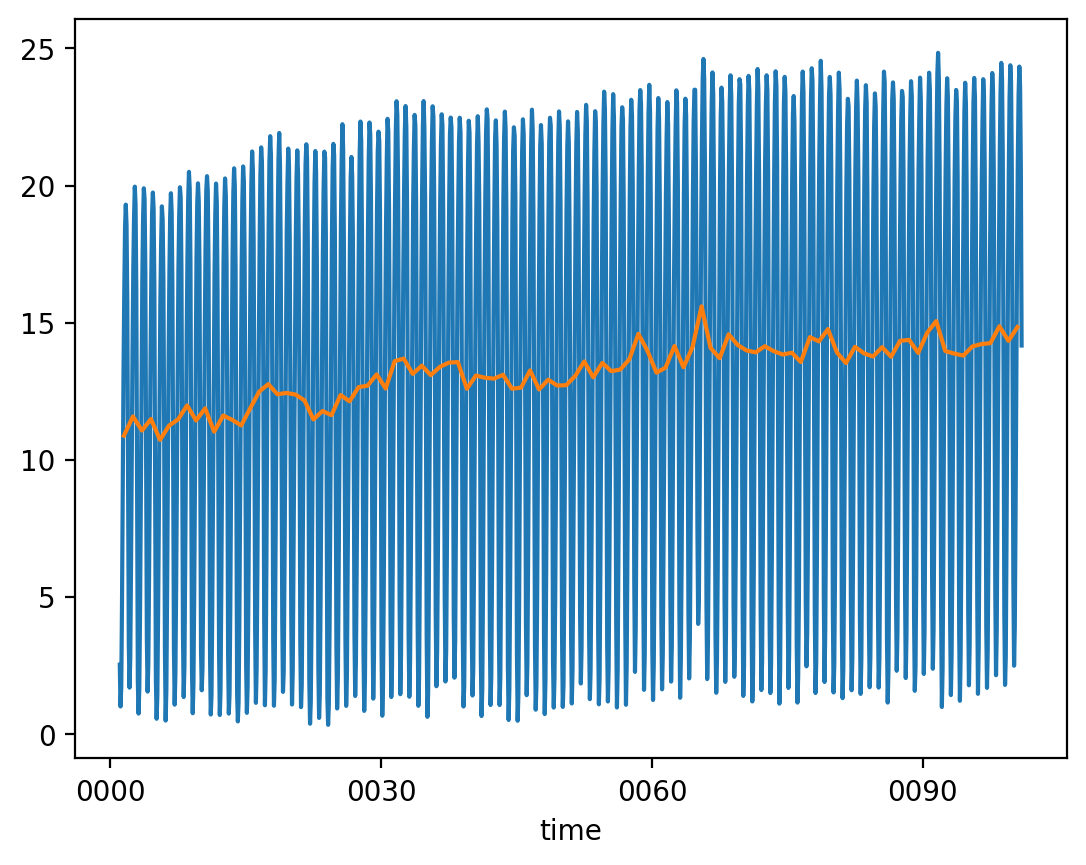

In [27]:
# Monthly Time Series for Projected data
ice_antwater = ice.where(ice>0.15)
#ice_antwater.isel(time=0).plot()

ice_antwater_monthly = ice_antwater.sel(yT=slice(-90,-30)).mean(dim=('xT', 'yT'))
ice_antwater_annual = ml.util.annual_average(ice_antwater_monthly, tcoord='time')
ice_antwater_annual


ice_antwater_area = ice_antwater* static.area
ice_antwater_area_antarctic_monthly= ice_antwater_area.sel(yT=slice(-90, -30)).sum(dim=('xT', 'yT'))
ice_antwater_area_antarctic_annual = ml.util.annual_average(ice_antwater_area_antarctic_monthly, tcoord='time')
ice_antwater_area_antarctic_monthly_km2 = (ice_antwater_area_antarctic_monthly * (1e-6)*(1e-6)) # convert m^2 to km^2
ice_antwater_area_antarctic_annual_km2 = (ice_antwater_area_antarctic_annual * (1e-6)*(1e-6))

ice_antwater_area_antarctic_monthly_km2.plot()
ice_antwater_area_antarctic_annual_km2.plot()

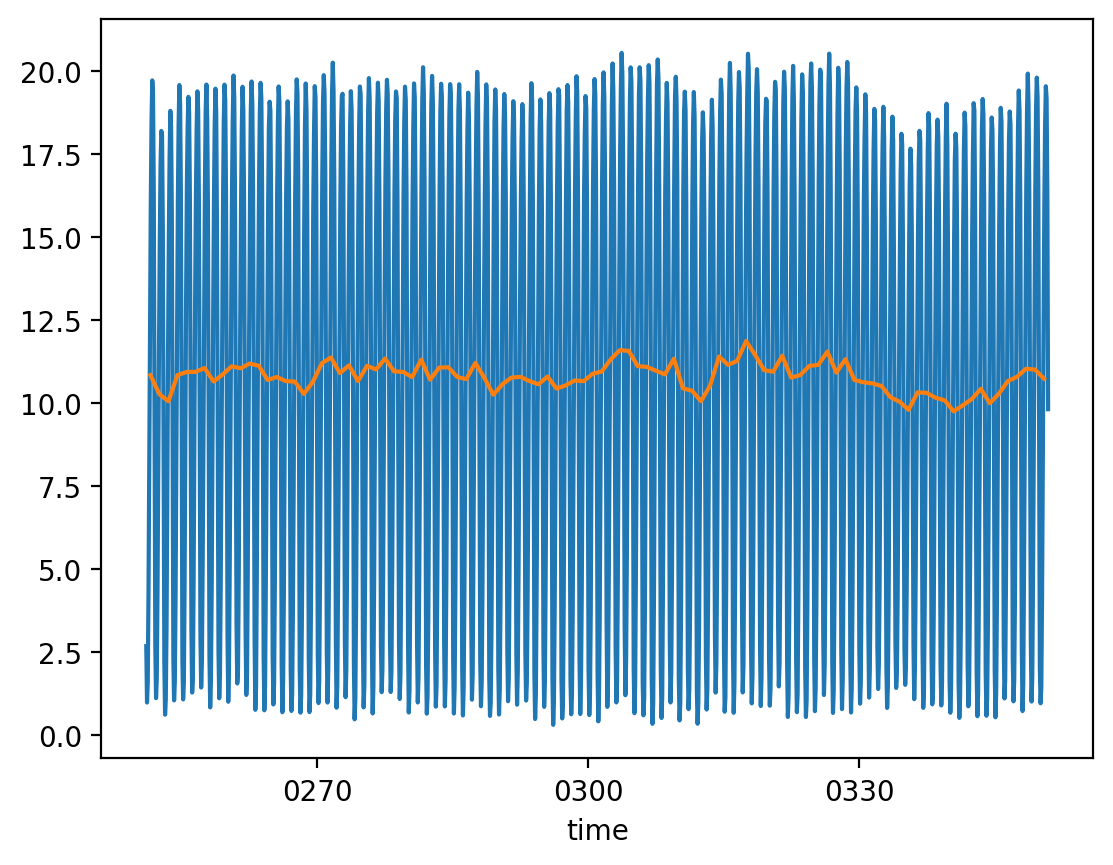

In [28]:
pi_antwater = PIice.where(PIice>0.15)


pi_antwater_monthly = pi_antwater.sel(yT=slice(-90,-30)).mean(dim=('xT', 'yT'))
pi_antwater_annual = ml.util.annual_average(pi_antwater_monthly, tcoord='time')
pi_antwater_annual_fraction = (pi_antwater_annual/100)
pi_antwater_annual_fraction

pi_antwater_area = pi_antwater* static.area
pi_antwater_area_antarctic_monthly= pi_antwater_area.sel(yT=slice(-90, -30)).sum(dim=('xT', 'yT'))
pi_antwater_area_antarctic_monthly_fraction = (pi_antwater_area_antarctic_monthly/100)
pi_antwater_area_antarctic_annual = ml.util.annual_average(pi_antwater_area_antarctic_monthly, tcoord='time')
pi_antwater_area_antarctic_annual_fraction = (pi_antwater_area_antarctic_annual/100)
pi_antwater_area_antarctic_annual_fraction
pi_antwater_area_antarctic_monthly_fraction_km2 = (pi_antwater_area_antarctic_monthly_fraction * (1e-6)*(1e-6)) # convert m^2 to km^2
pi_antwater_area_antarctic_annual_fraction_km2 = (pi_antwater_area_antarctic_annual_fraction * (1e-6)*(1e-6))

pi_antwater_area_antarctic_monthly_fraction_km2.plot()
pi_antwater_area_antarctic_annual_fraction_km2.plot()

/tmp/ipykernel_1100722/959394982.py:10: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(['ice_antwater_area_antarctic_annual_km2', 'pi_antwater_area_antarctic_annual_fraction_km2'], labels=['Antwater', 'PiControl'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


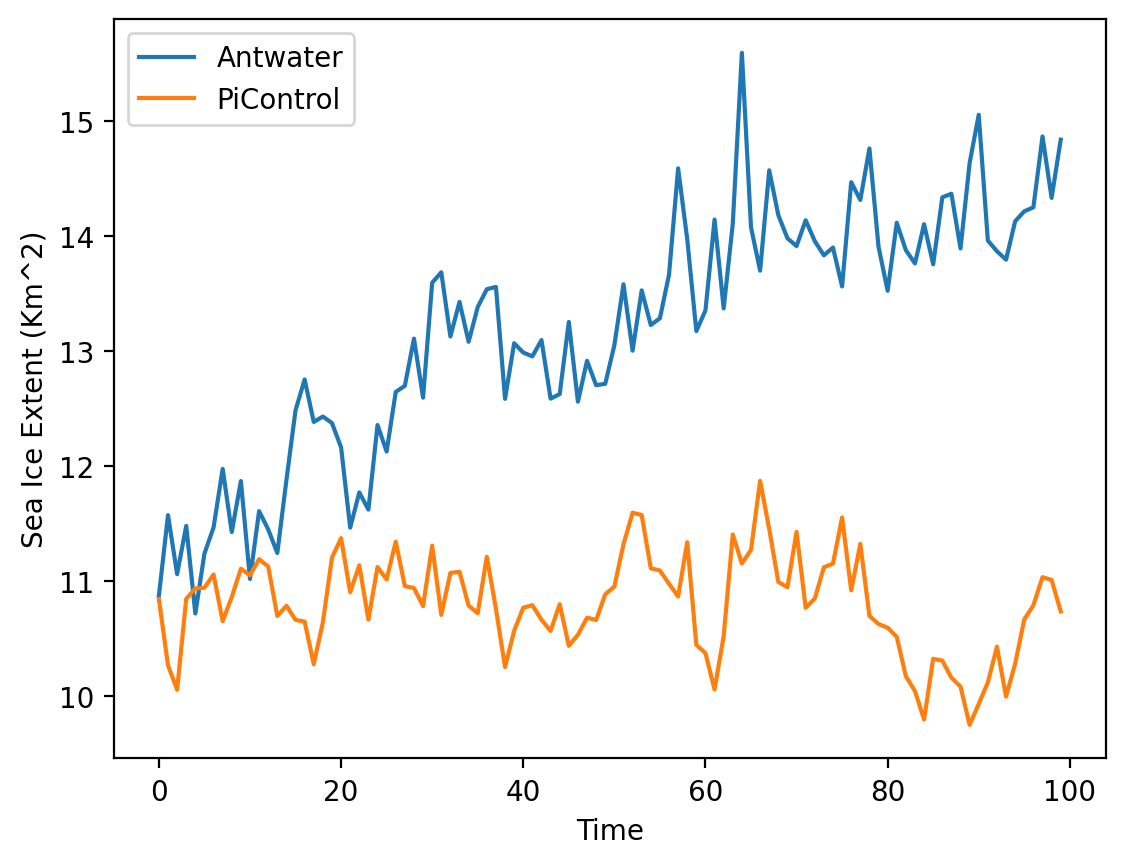

In [29]:
# PICONT YEARLY AND ICE YEARLY
(pi_antwater_area_antarctic_annual_fraction * (1e-6)*(1e-6))
(ice_antwater_area_antarctic_annual * (1e-6)*(1e-6))

plt.plot(ice_antwater_area_antarctic_annual_km2)
plt.plot(pi_antwater_area_antarctic_annual_fraction_km2)
plt.ylabel("Sea Ice Extent (Km^2)")
plt.xlabel("Time")

plt.legend(['ice_antwater_area_antarctic_annual_km2', 'pi_antwater_area_antarctic_annual_fraction_km2'], labels=['Antwater', 'PiControl'])
ax.legend()

#plt.legend('Sea Ice Extent')


In [30]:
# calculate mean area and standard deviation values for picontrol 
pi_mean = (pi_antwater_area_antarctic_annual_fraction * (1e-6)*(1e-6)).mean().values
pi_std = (pi_antwater_area_antarctic_annual_fraction * (1e-6)*(1e-6)).std().values

print(pi_mean)
print(pi_std)

10.801048707019033
0.4234195379711918


### The average ice extent area in the picontrol model is 10.8 km^2 with a standard deviation of ± 0.42

In [31]:
# calculate mean area and standard deviation values for ice
ice_mean = (ice_antwater_area_antarctic_annual * (1e-6)*(1e-6)).mean().values
ice_std = (ice_antwater_area_antarctic_annual * (1e-6)*(1e-6)).std().values

print(ice_mean)
print(ice_std)

13.180090146001737
1.0683981562116676


### The average ice extent area in the 100 year average antwater model is 13.18 km^2 with a standard deviation of ± 1.07

In [32]:
# last twenty years mean
ice_antwater_timeslice = (ice_antwater_area_antarctic_annual * (1e-6)*(1e-6)).sel(time=slice("0080-01-16", "0100-12-16"))
last_twenty_mean = ice_antwater_timeslice.mean().values

# last twenty years standard deviation
last_twenty_std = ice_antwater_timeslice.std().values

print(last_twenty_mean)
print(last_twenty_std)

14.17136093525841
0.3963677190356442


### The average ice extent area for the last twenty years of the antwater model is 14.17 km^2 with a standard deviation of ± 0.40

In [33]:
# amount sea ice average expanded by from picontrol to antwater model 
ice_expansion = ice_mean - pi_mean

# percent change 
ice_percent_change = (ice_mean - pi_mean)/ pi_mean

print(ice_expansion)
print(ice_percent_change)

2.3790414389827035
0.2202602269015498


### Sea ice expanded by 22% or 2.37 million km^2 from preindustrial times to the 100 year average antwater model

In [34]:
# amount sea ice average expanded from picontrol to the last twenty years of the model 
last_twenty_expansion = last_twenty_mean - pi_mean

# percent change
last_twenty_percent_change = (last_twenty_mean - pi_mean)/pi_mean

print(last_twenty_expansion)
print(last_twenty_percent_change)

3.370312228239376
0.31203564761717884


### Sea ice expanded by 31% or 3.37 million km^2 from preindustrial times to the last twenty year average of the antwater model 

In [35]:
ice

<xarray.DataArray 'siconc' (time: 1200, yT: 1080, xT: 1440)>
dask.array<concatenate, shape=(1200, 1080, 1440), dtype=float32, chunksize=(1, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0100-12-16 12:00:00
  * xT       (xT) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yT       (yT) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
    geolat   (yT, xT) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    geolon   (yT, xT) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
Attributes:
    long_name:      ice concentration
    units:          0-1
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [36]:
pi_antwater = PIice.where(PIice>15)
ice_antwater = ice.where(ice>.15)

In [37]:
ice_antwater

monthly_ice_area = ice_antwater * static.area 
monthly_ice_ave = monthly_ice_area.sel(time=slice("0080-01-16", "0100-12-16")).sel(yT=slice(-90, -30)).groupby('time.month').mean(dim='time').sum(dim=('xT', 'yT'))
monthly_ice_std = monthly_ice_area.sel(time=slice("0080-01-16", "0100-12-16")).sel(yT=slice(-90, -30)).groupby('time.month').std(dim='time').sum(dim=('xT', 'yT'))
monthly_ice_conc = (monthly_ice_ave * (1e-6)*(1e-6))



monthly_ice_pi_area = pi_antwater * static.area  
monthly_ice_pi_ave = monthly_ice_pi_area.sel(yT=slice(-90, -30)).groupby('time.month').mean(dim='time').sum(dim=('xT', 'yT')) / 100
monthly_ice_pi_std = monthly_ice_pi_area.sel(yT=slice(-90, -30)).groupby('time.month').std(dim='time').sum(dim=('xT', 'yT'))  / 100
monthly_ice_piconc = (monthly_ice_pi_ave * (1e-6)*(1e-6)) 


monthly_ice_pi_ave_m2sigma = monthly_ice_pi_ave - (2 * monthly_ice_pi_std)
monthly_ice_pi_ave_p2sigma = monthly_ice_pi_ave +(2 * monthly_ice_pi_std)

monthly_ice_ave_p2sigma = monthly_ice_ave + (2 * monthly_ice_std)
monthly_ice_ave_m2sigma = monthly_ice_ave - (2 * monthly_ice_std)



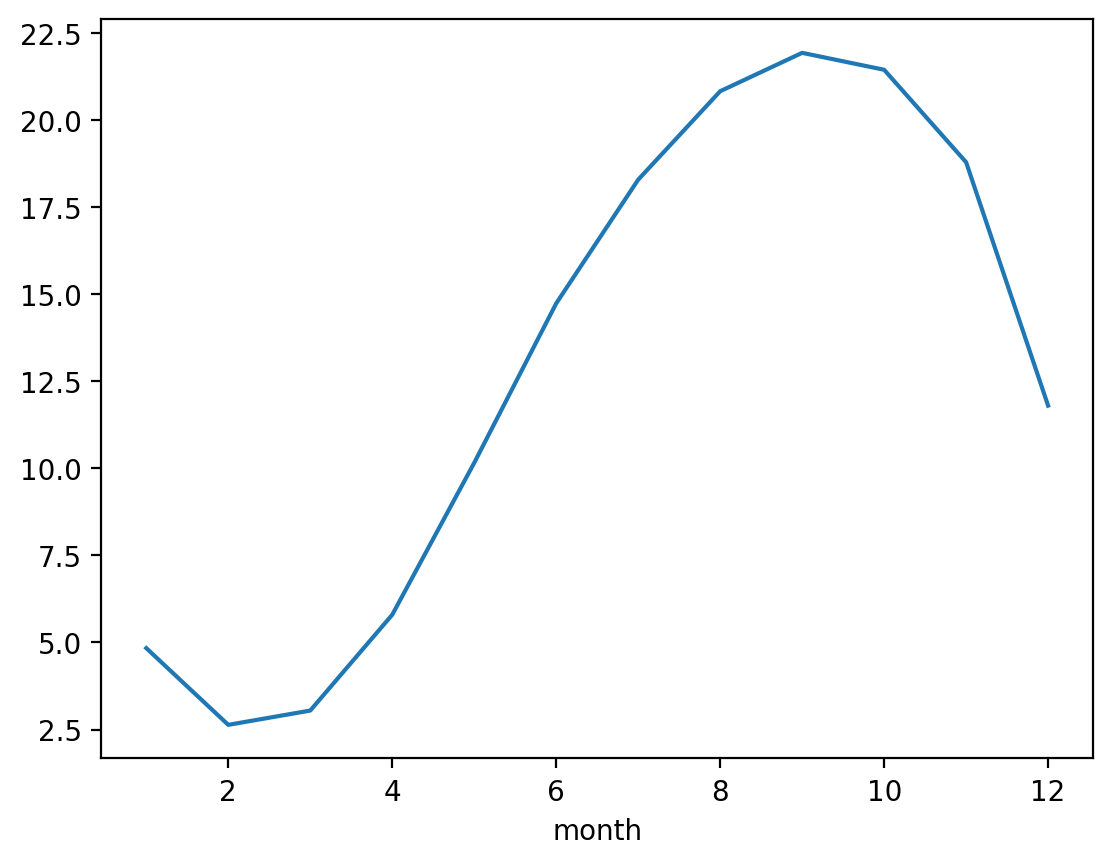

In [38]:
monthly_ice_piconc.plot()

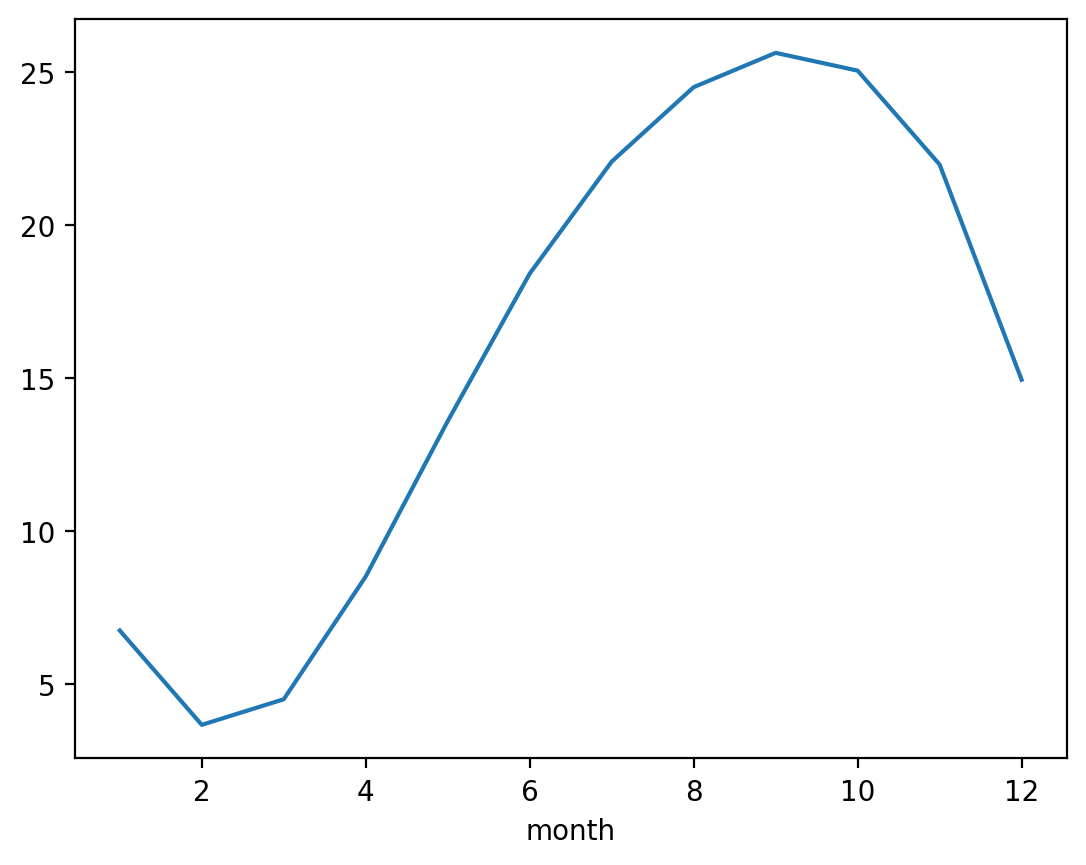

In [39]:
monthly_ice_conc.plot()

In [41]:
yerrp = (monthly_ice_pi_ave_p2sigma * ((1e-6)*(1e-6))) 

yerrm = (monthly_ice_pi_ave_m2sigma * ((1e-6)*(1e-6))) 

#xaxis_ice
#ax.fill_between('month' ,yerrm, yerrp,facecolor='grey',alpha=0.5)

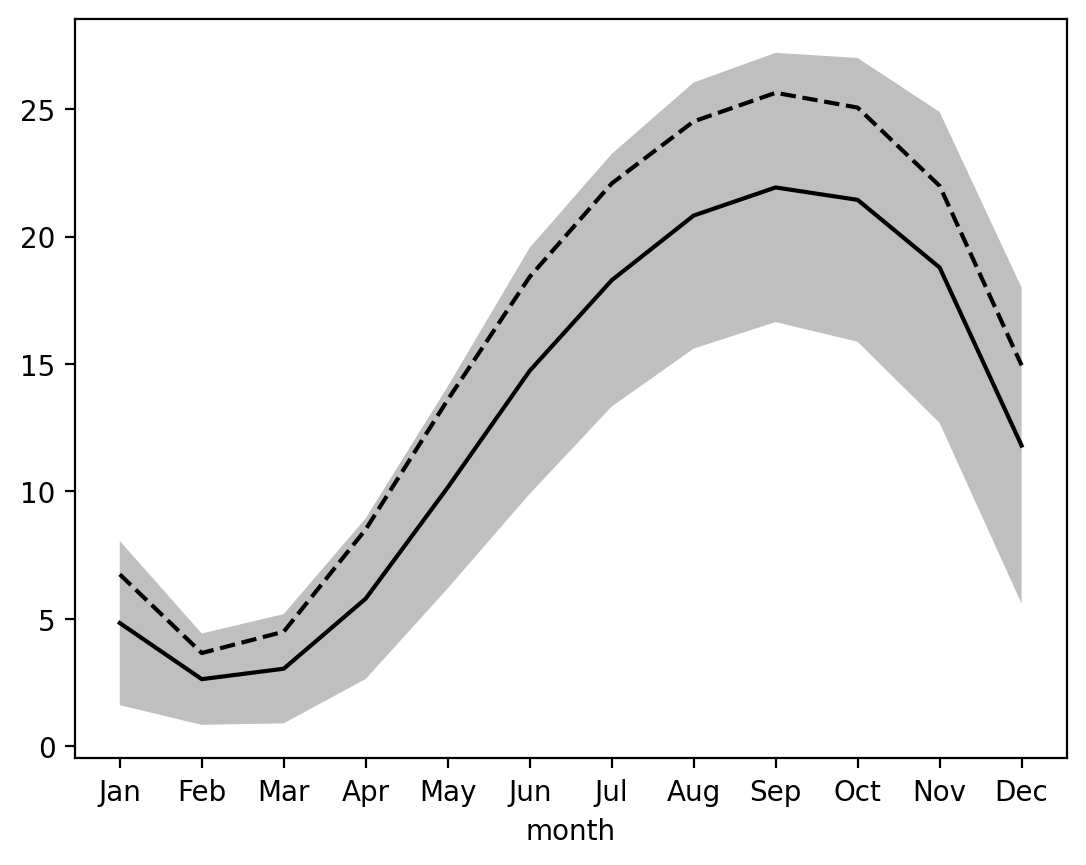

In [46]:
monthly_ice_piconc.plot(color='k')
yerrm.plot(linewidth=0)
yerrp.plot(linewidth=0)
monthly_ice_conc.plot(color='k', linestyle='--')

plt.xticks([1, 2, 3, 4, 5, 6, 7,  8, 9, 10, 11, 12],
              ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

plt.fill_between(monthly_ice_piconc['month'],yerrm, yerrp, facecolor='grey',alpha=0.5)